In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# import basic libraries from tensorflow
import tensorflow as tf
from tensorflow import keras


In [6]:
!ls

__notebook_source__.ipynb


In [7]:
!pwd

/kaggle/working


In [8]:

train = pd.read_csv('/kaggle/input/traincsv/train.csv')
train.tail()

,image,labels
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot
18631,fffe472a0001bd25.jpg,healthy


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18632 entries, 0 to 18631
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   18632 non-null  object
 1   labels  18632 non-null  object
dtypes: object(2)
memory usage: 291.2+ KB


In [10]:
train.labels.value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

In [11]:
temp = ['scab frog_eye_leaf_spot',
'scab frog_eye_leaf_spot complex',
'frog_eye_leaf_spot complex',
'rust frog_eye_leaf_spot',
'rust complex',
'powdery_mildew complex'] 

In [12]:
train.replace(to_replace= temp,value =pd.NA,inplace=True)

In [13]:
train.dropna(axis=0,inplace=True)

In [14]:
train.reset_index(drop=True,inplace=True)

In [15]:
train.labels.value_counts()

scab                  4826
healthy               4624
frog_eye_leaf_spot    3181
rust                  1860
complex               1602
powdery_mildew        1184
Name: labels, dtype: int64

In [25]:
train_cl = pd.get_dummies(train, columns=['labels'])
train_cl['labels'] = train.labels

In [26]:

train_cl.rename(columns  = {'labels_complex':'complex',
                     'labels_frog_eye_leaf_spot':'frog_eye_leaf_spot',
                     'labels_healthy':'healthy',
                     'labels_powdery_mildew':'powdery_mildew',
                     'labels_rust':'rust',
                     'labels_scab':'scab'},inplace=True)

<AxesSubplot:>

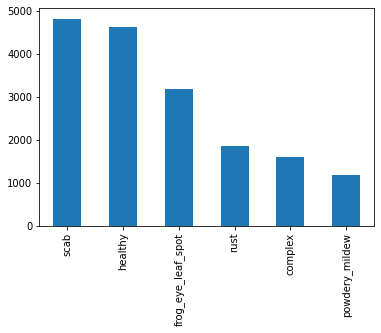

In [27]:
train_cl.labels.value_counts().plot(kind='bar')

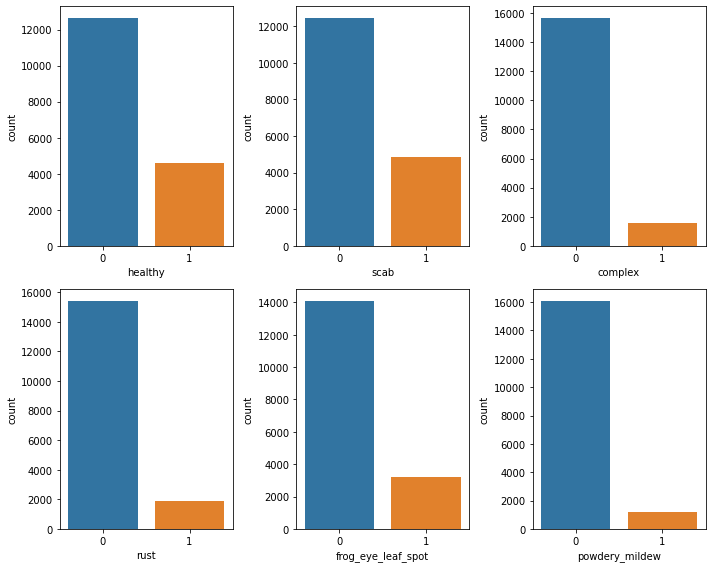

In [28]:
import seaborn as sns
#  Categorical Data
a = 2  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(10,8))

for i in train_cl.labels.unique():
    plt.subplot(a, b, c)
    sns.countplot(x =train_cl[i])
    c = c + 1
plt.tight_layout()
plt.show()

In [29]:
train_cl

,image,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab,labels
0,800113bb65efe69e.jpg,0,0,1,0,0,0,healthy
1,80070f7fb5e2ccaa.jpg,0,0,0,0,0,1,scab
2,80077517781fb94f.jpg,0,0,0,0,0,1,scab
3,800cbf0ff87721f8.jpg,1,0,0,0,0,0,complex
4,800edef467d27c15.jpg,0,0,1,0,0,0,healthy
...,...,...,...,...,...,...,...,...
17272,fffb65761200b054.jpg,0,0,1,0,0,0,healthy
17273,fffb900a92289a33.jpg,0,0,1,0,0,0,healthy
17274,fffc488fa4c0e80c.jpg,0,0,0,0,0,1,scab
17275,fffc94e092a59086.jpg,0,0,0,0,1,0,rust


In [35]:
class_labels = list(train_cl.columns[1:-1])
class_labels

['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1/255,
                                rotation_range=20,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                horizontal_flip=True,
                                vertical_flip = True,
                                validation_split = 0.2 )

# '/kaggle/input/resized-plant2021/img_sz_384'
train_dataset = train_datagen.flow_from_dataframe(
    train_cl,
    directory = "/kaggle/input/resized-plant2021/img_sz_384",
    x_col = "image",
    y_col = class_labels,
    subset = 'training',
    class_mode='raw',
    color_mode = 'rgb',
    batch_size = 64,
    shuffle = True,
    target_size = (384,384))

validation_dataset = train_datagen.flow_from_dataframe(
    train_cl,
    directory = '/kaggle/input/resized-plant2021/img_sz_384',
    x_col = "image",
    y_col = class_labels,
    subset = 'validation',
    class_mode='raw',
    color_mode = 'rgb',
    batch_size = 64,
    shuffle = True,
    target_size = (384,384))


Found 13822 validated image filenames.
Found 3455 validated image filenames.


In [58]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D, MaxPooling2D,BatchNormalization, Dense, Flatten, Dropout

In [59]:
from tensorflow.keras.applications import InceptionV3,MobileNetV3Small

mob_v3 = MobileNetV3Small(input_shape=(384,384,3),
                          include_top=False,
                          weights="imagenet")
inceptionv3_model = InceptionV3(input_shape=(384, 384, 3),
                                include_top=False, 
                                 weights="imagenet")

In [60]:
inceptionv3_model.output

<KerasTensor: shape=(None, 10, 10, 2048) dtype=float32 (created by layer 'mixed10')>

In [61]:
inceptionv3_model.input

<KerasTensor: shape=(None, 384, 384, 3) dtype=float32 (created by layer 'input_9')>

In [62]:

x = inceptionv3_model.output
x = GlobalAveragePooling2D()(x)
#fully connected layer
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(16, activation='relu')(x)
preds = Dense(6, activation='softmax')(x)

final_Inception_model = Model(inputs=inceptionv3_model.input, 
                              outputs=preds)

In [63]:
'''model = Sequential()
model.add(mob_v3)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(64,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))
model.summary()'''

"model = Sequential()\nmodel.add(mob_v3)\nmodel.add(GlobalAveragePooling2D())\nmodel.add(Dropout(0.3))\nmodel.add(Dense(64,activation = 'relu'))\nmodel.add(Dropout(0.3))\nmodel.add(Dense(6, activation='softmax'))\nmodel.summary()"

In [64]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('my_model.hdf5',
                             verbose=1,save_best_only=True,
                             monitor = 'val_accuracy')

In [65]:
# apply mobile v3 model
final_Inception_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

history = final_Inception_model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    shuffle = True,
                    callbacks = checkpoint)

Epoch 1/10
216/216 [==============================] - 660s 3s/step - loss: 0.7104 - accuracy: 0.7647 - val_loss: 1.3539 - val_accuracy: 0.7708

Epoch 00001: val_accuracy improved from -inf to 0.77077, saving model to my_model.hdf5
Epoch 2/10
216/216 [==============================] - 634s 3s/step - loss: 0.4734 - accuracy: 0.8596 - val_loss: 0.8201 - val_accuracy: 0.7673

Epoch 00002: val_accuracy did not improve from 0.77077
Epoch 3/10
216/216 [==============================] - 640s 3s/step - loss: 0.3958 - accuracy: 0.8848 - val_loss: 0.7577 - val_accuracy: 0.7783

Epoch 00003: val_accuracy improved from 0.77077 to 0.77829, saving model to my_model.hdf5
Epoch 4/10
216/216 [==============================] - 642s 3s/step - loss: 0.3634 - accuracy: 0.8913 - val_loss: 1.9372 - val_accuracy: 0.7071

Epoch 00004: val_accuracy did not improve from 0.77829
Epoch 5/10
216/216 [==============================] - 638s 3s/step - loss: 0.3381 - accuracy: 0.9000 - val_loss: 0.8319 - val_accuracy: 0

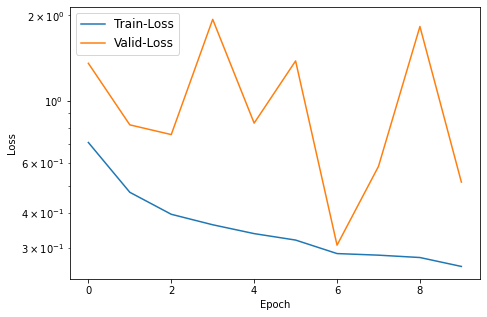

In [74]:

fig = plt.figure(figsize=(25, 5))
# "Loss"
fig.add_subplot(132)
plt.plot(history.history['loss'], label='Train-Loss')
plt.plot(history.history['val_loss'], label='Valid-Loss')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(fontsize=12)



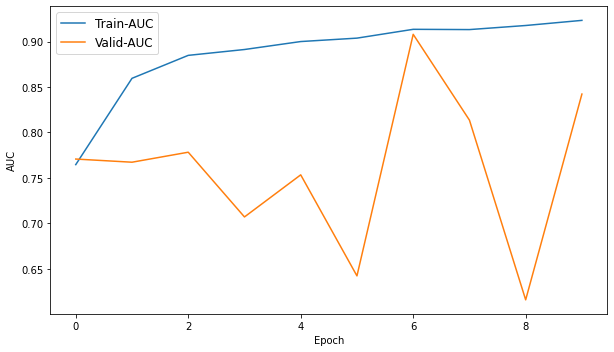

In [76]:

fig = plt.figure(figsize=(25, 5))
# "AUC"
fig.add_subplot(133)
plt.plot(history.history['accuracy'], label='Train-AUC')
plt.plot(history.history['val_accuracy'], label='Valid-AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()